In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
delta_t = 0.01

In [3]:
columns = ['roll', 'pitch', 'yaw', 'rps', 'fin1', 'fin2', 'fin3', 'fin4']
data = []
with open('./data_20240714_135554.txt', 'r') as f:
    data = [l.strip()[:-1] for l in f.readlines() if len(l.strip()) > 0]
data = [[float(_d) for _d in d.split(',')] for d in data]
data = np.array(data)
df_raw_data = pd.DataFrame(data=data, columns=columns)
df_raw_data

,roll,pitch,yaw,rps,fin1,fin2,fin3,fin4
0,0.47,-0.16,0.04,0.01,-30.0,30.0,30.0,-30.0
1,0.48,-0.14,0.16,0.01,-30.0,30.0,30.0,-30.0
2,0.48,-0.12,0.28,0.01,-30.0,30.0,30.0,-30.0
3,0.46,-0.12,0.41,0.01,-30.0,30.0,30.0,-30.0
4,0.44,-0.13,0.50,0.01,-30.0,30.0,30.0,-30.0
...,...,...,...,...,...,...,...,...
1812,-3.23,-2.18,29.45,0.01,-30.0,30.0,30.0,-30.0
1813,-3.46,-2.21,29.42,0.01,30.0,30.0,30.0,-30.0
1814,-3.90,-2.24,28.92,0.01,30.0,-30.0,30.0,-30.0
1815,-4.24,-2.31,28.37,0.01,30.0,-30.0,30.0,-30.0


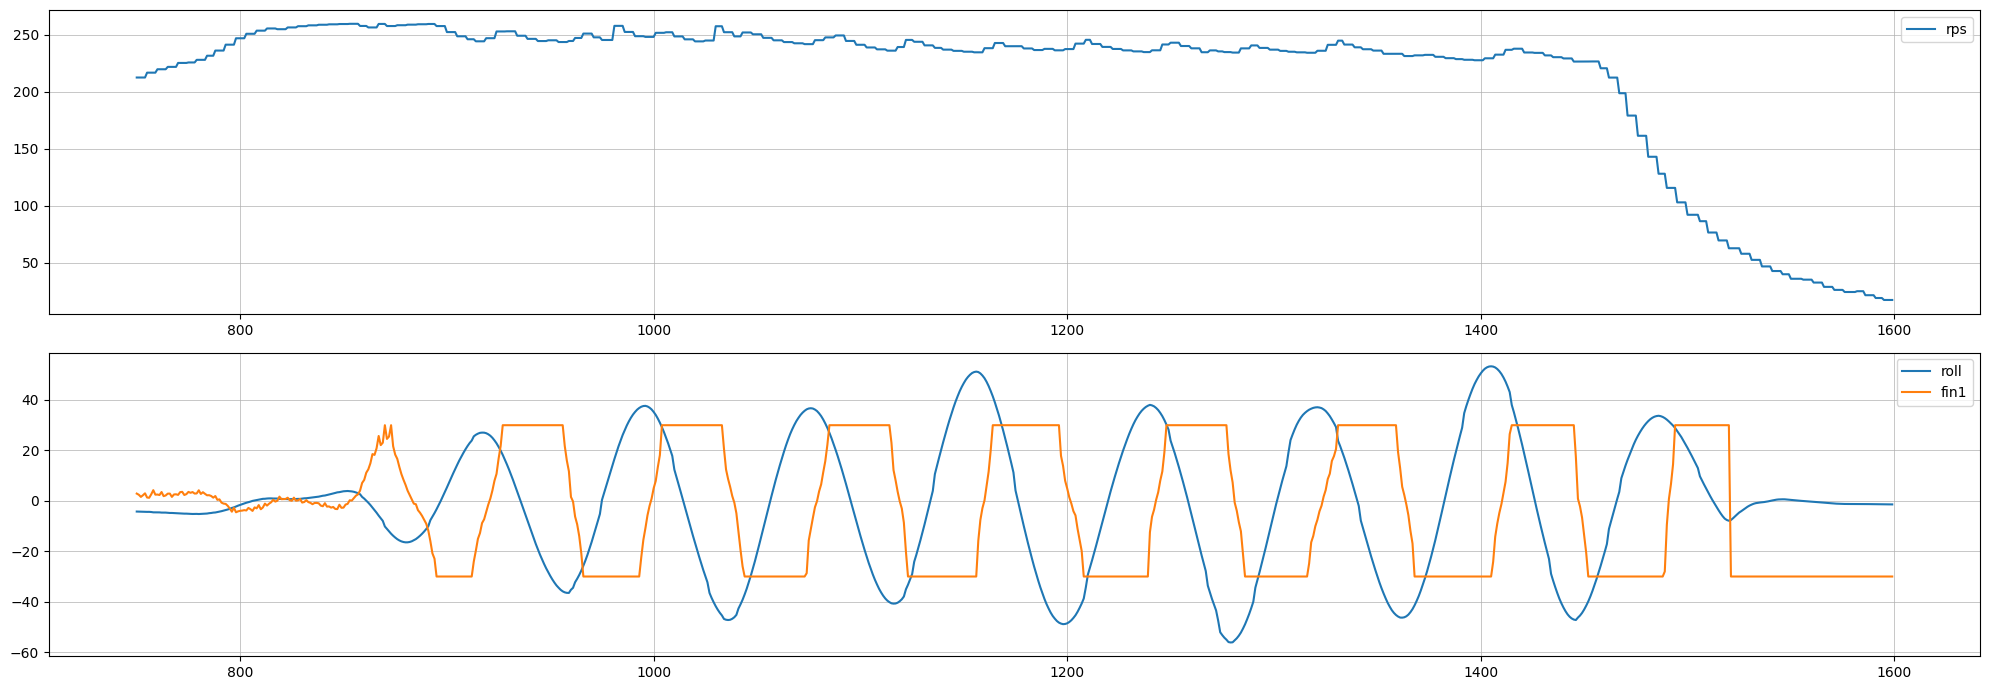

In [4]:
plt.figure(figsize=(20,7))

df = df_raw_data[750:1600]

columns_to_plot = ['rps']
plt.subplot(2,1,1)
plt.plot(df[columns_to_plot])
plt.legend(columns_to_plot)
plt.grid(which='both', linewidth=0.5)

columns_to_plot = ['roll', 'fin1']
plt.subplot(2,1,2)
plt.plot(df[columns_to_plot])
plt.legend(columns_to_plot)
plt.grid(which='both', linewidth=0.5)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [21]:
def solve_quadratic(a, b, c, y):
    c_prime = c - y
    discriminant = b**2 - 4*a*c_prime

    if discriminant > 0:
        x1 = (-b + math.sqrt(discriminant)) / (2 * a)
        x2 = (-b - math.sqrt(discriminant)) / (2 * a)
        return (x1, x2)
    elif discriminant == 0:
        x = -b / (2 * a)
        return (x,)
    else:
        # No real roots
        return ()

class Craft:
    area_of_prop_blade = 3.334e-3
    propeller_pitch = 10.67 / 100
    density_of_air = 1.293
    
    # c + bx + ax^2 = 0
    coef_of_lift_equation = np.array([ 0.0, 0.03789802668726148, -0.00061862700596408])
    
    def __init__(self, area_of_fin):
        self.area_of_fin = area_of_fin
        pass
    
    def get_wind_speed_from_rps(self, rps):
        return rps * self.propeller_pitch * 0.9
    
    def get_coeff_of_lift(self, force, wind_speed):
        return 2 * force / (self.density_of_air * self.area_of_fin * (wind_speed**2))
    
    def get_fin_angle_from_coef_of_lift(self, cl):
        max_angle = 30
        roots = solve_quadratic(self.coef_of_lift_equation[2], self.coef_of_lift_equation[1], self.coef_of_lift_equation[0], cl)
        if len(roots) == 2:
            if roots[0] >= 0 and roots[0] <= max_angle and roots[1] >= 0 and roots[1] <= max_angle:
                angle = min(roots[0], min[roots[1]])
            elif roots[0] >= 0 and roots[0] <= max_angle:
                angle = roots[0]
            elif roots[1] >= 0 and roots[1] <= max_angle:
                angle = roots[1]
            else:
                # need to work
                angle = 0
        elif len(roots) == 1:
            if roots[0] < 0:
                angle = 0
            elif roots[0] > max_angle:
                angle = max_angle
        else:
            angle = max_angle
    
        return angle
    
    def get_fin_angle_from_force(self, force, rps):
        wind_speed = self.get_wind_speed_from_rps(rps)
        cl = self.get_coeff_of_lift(abs(force), wind_speed)
        fin_angle = self.get_fin_angle_from_coef_of_lift(cl)
        return fin_angle * (force / abs(force))

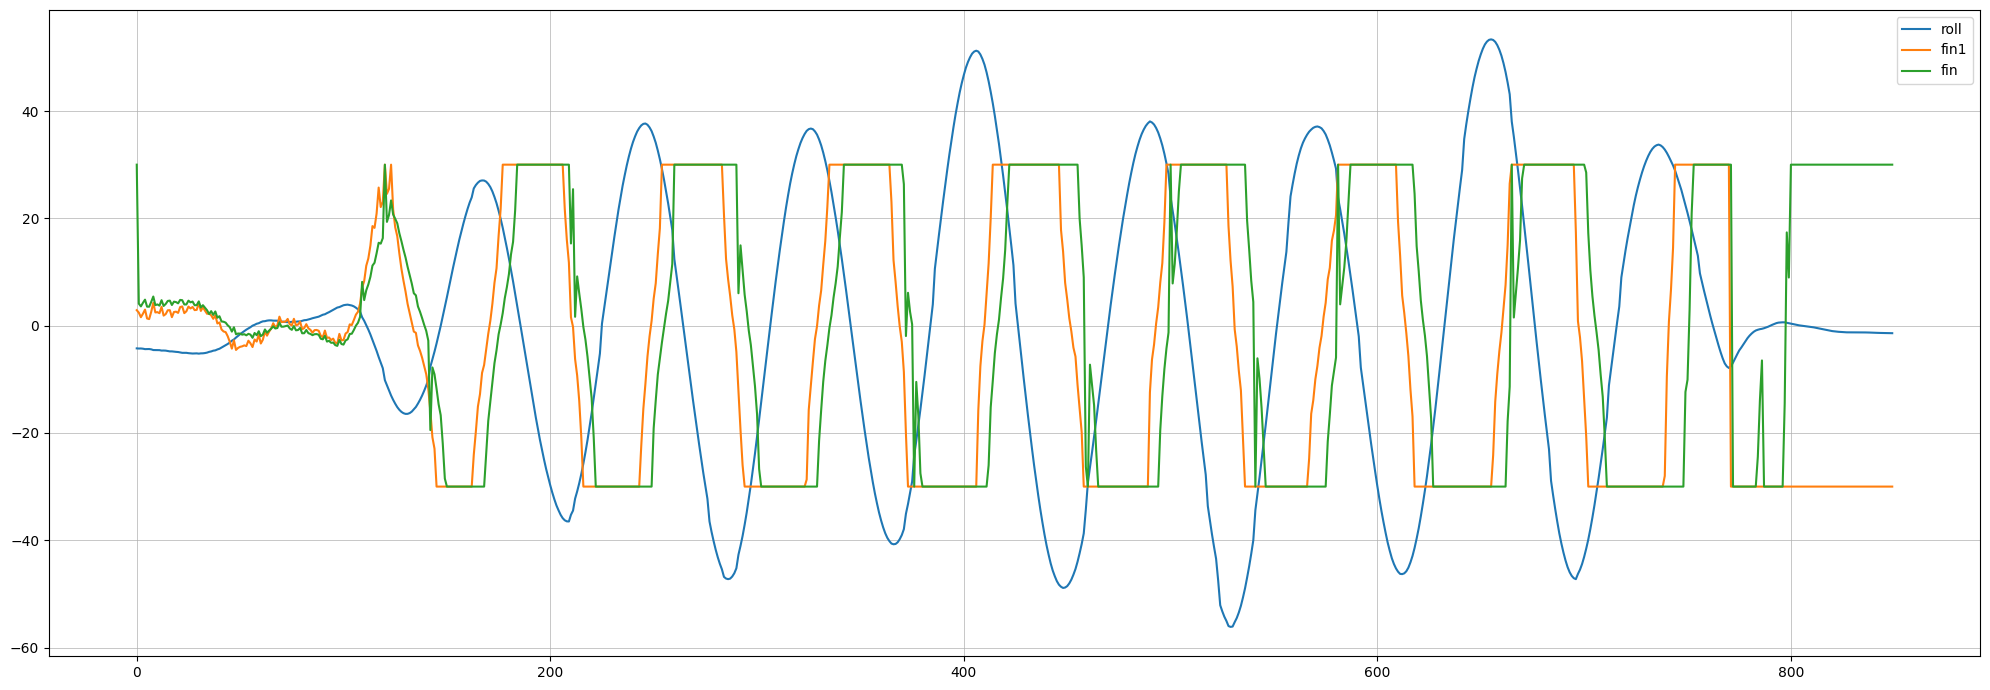

In [52]:
area_of_fin = 0.00318
craft = Craft(area_of_fin)
KP, KI, KD = 15, 0, 2
pid_factor = 0.0017696

target_angle = 0
prev_error = 0
pid_i = 0
fin_angles = []

for rps, roll in df[['rps', 'roll']].values:
    error = target_angle - roll

    pid_p = error * KP
    if abs(error) < 5:
        pid_i += error * KI
    else:
        pid_i = 0

    pid_d = (error - prev_error) * KD / delta_t

    pid = (pid_p + pid_i + pid_d) * pid_factor
    prev_error = error
    
    fin_angle = craft.get_fin_angle_from_force(pid, rps)
    fin_angles.append(fin_angle)

fin_angles = np.array(fin_angles)
    

plt.figure(figsize=(20,7))

columns_to_plot = ['roll', 'fin1']
plt.plot(df[columns_to_plot].values)
plt.plot(fin_angles)
# plt.scatter(range(len(df['roll'].values)), df['roll'].values, c='r', s=5)
# plt.legend(columns_to_plot)
plt.legend(['roll', 'fin1', 'fin'])
plt.grid(which='both', linewidth=0.5)


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()